In [1]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
library(ggplot2)
library(ggpubr)
library(ggExtra)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate




# Get GATA3 Motif Score

In [2]:
meta_data<-read.csv('03_TEAseq_PenSenior/meta_data_GEO.csv')
meta_data<-meta_data[c('combined_sample_id','subject_id.ch1')]
colnames(meta_data)[1]<-'Sample'

df<-read.csv('03_TEAseq_PenSenior/Motif_Mean_Score.csv')

In [3]:
df<-df %>% filter(AIFI_L3=='CM CD4 T cell') 
df_filtered<-df[grepl('Sample|GATA3',colnames(df))]

In [4]:
Motif_Score_mean <- df_filtered %>%
  left_join(meta_data) %>%
  mutate('Age Group' = case_when(
    startsWith(subject_id.ch1, "BR2") ~ "Older",
    TRUE ~ 'Childern' 
  ))

Joining with `by = join_by(Sample)`


In [5]:
#Motif_Score_mean$Variable<-gsub("motif_","",Motif_Score_mean$Variable)
Motif_Score_mean$pbmc_sample_id<- sub(".*_", "", Motif_Score_mean$Sample)


# Get Th2 Score

In [6]:
NMF_Score<-read.csv('03_TEAseq_PenSenior/NMF_Score_CD4_T.csv')

In [7]:
NMF_Score_mean<-NMF_Score%>%
  group_by(pbmc_sample_id, AIFI_L3) %>%
  dplyr::summarise(across(contains("NMF"), ~ mean(as.numeric(.), na.rm = TRUE), 
                          .names = "{col}"), .groups = 'drop')

In [8]:
NMF_Score_mean<-NMF_Score_mean %>% filter(AIFI_L3=='CM CD4 T cell')

# Combine Th2 Score and GATA3 mofit

In [9]:
df<-left_join(NMF_Score_mean,Motif_Score_mean)

Joining with `by = join_by(pbmc_sample_id)`


In [10]:
df_subset<-df[,grepl('GATA3|Th2|pbmc|Sample|AIFI_L3',colnames(df))]

In [11]:
df_subset <- left_join(df_subset, meta_data, by = c("Sample" = "Sample")) %>%
  mutate('Age Group' = case_when(
    startsWith(subject_id.ch1, "BR2") ~ "Older",
    TRUE ~ 'Childern' 
  ))


In [12]:
head(df_subset)

pbmc_sample_id,AIFI_L3,NMF5_Th2,Sample,motif_GATA3_384,subject_id.ch1,Age Group
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
PB00124-02,CM CD4 T cell,0.01447445,GSM6611371_B076-P1_PB00124-02,-0.04995587,UP1001,Childern
PB00127-02,CM CD4 T cell,0.01369823,GSM6611374_B076-P1_PB00127-02,-0.06413569,UP1004,Childern
PB00172-02,CM CD4 T cell,0.01319003,GSM6611372_B069-P1_PB00172-02,-0.07342110,UP1002,Childern
PB00173-02,CM CD4 T cell,0.02502390,GSM6611376_B065-P1_PB00173-02,-0.02465236,UP1006,Childern
PB00182-02,CM CD4 T cell,0.02777926,GSM6611373_B069-P1_PB00182-02,-0.04287844,UP1003,Childern
PB00192-02,CM CD4 T cell,0.02234688,GSM6611377_B065-P1_PB00192-02,-0.06033524,UP1007,Childern


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


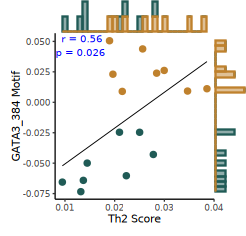

In [22]:
options(repr.plot.width = 52/25.4, repr.plot.height =50/25.4)
correlation_tests <- df_subset %>%
  dplyr::summarise(
    correlation = cor(NMF5_Th2, motif_GATA3_384, method = 'spearman'),
    p_value = cor.test(NMF5_Th2, motif_GATA3_384, method = 'spearman')$p.value
  )
p <- ggplot(df_subset) +
  geom_point(aes(x = NMF5_Th2, y = motif_GATA3_384, color = `Age Group`),  shape = 16) +  

  theme_classic(base_size = 6) +
  theme(legend.position = "none") + 
  labs(x = "Th2 Score", y = "GATA3_384 Motif") +    
geom_smooth(aes(x = NMF5_Th2, y = motif_GATA3_384, color = "black"),
            se=FALSE, method='lm',linewidth=0.2, color='black') +

    scale_color_manual(values = c("Older" = '#bf812d', "Childern" = '#205B56'))+
  geom_text(
    data = correlation_tests,
    aes(
      x = 0.019, y = Inf,
      label = paste("r =", round(correlation, 2), "\np =", format.pval(p_value, digits = 2, eps = 0.001)),
      hjust = 1.1, vjust = 1.1
    ),
    inherit.aes = FALSE,
    size = 2,
    color = "blue"
  )
p<-ggMarginal(p, type = "histogram", groupColour = TRUE, groupFill = TRUE)
p
ggsave('FigureM.pdf',p,width = 52/25.4,height = 50/25.4)